## Imports

In [47]:
import argparse
import os
import time
import sys
import random
import gc
import json
import pickle
from collections import Counter
from multiprocessing import Pool
from pathlib import Path

import mat73

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import nibabel as nib
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from IPython.display import Video, HTML

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

manualSeed = 111
SEED = manualSeed

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()


def reset_seed(seed=manualSeed):
    torch.manual_seed(seed)
    np.random.seed(seed)


os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

DATA_PATH = '/data/vladimiroved/realWorldTableTennis'
SUB_ID = '07'

## EDA

Your dataset is organized as follows for each subject (e.g., `sub-01`):

- **`anat` Folder**:
  - `sub-01_T1w.nii`: De-identified T1-weighted anatomical MRI scan in NIfTI format.

- **`eeg` Folder**:
  - `sub-01_task-TableTennis_eeg.set`: EEGLAB dataset file containing EEG data.
  - `sub-01_task-TableTennis_eeg.fdt`: EEGLAB binary data file associated with the `.set` file.
  - `sub-01_task-TableTennis_channels.tsv`: Tab-separated file with channel information.
  - `sub-01_task-TableTennis_coordsystem.json`: JSON file describing the coordinate system.
  - `sub-01_task-TableTennis_electrodes.tsv`: Tab-separated file with electrode positions.
  - `sub-01_task-TableTennis_events.tsv`: Tab-separated file with event information.
  - `sub-01_task-TableTennis_events.json`: JSON file describing the events.

In [23]:
eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
anat_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'anat/')

channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
electrodes_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_electrodes.tsv', sep='\t')
events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
participants_df = pd.read_csv(DATA_PATH + '/participants.tsv', sep='\t')

with open(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_coordsystem.json', 'rb') as fd:
    coord_system = json.load(fd)

with open(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.json', 'rb') as fd:
    events = json.load(fd)

with open(DATA_PATH + '/participants.json', 'rb') as fd:
    participants_json = json.load(fd)

### Data View

In [24]:
print(channels_df.shape)
channels_df.sample(5, random_state=SEED)

(270, 3)


,name,type,units
163,N-CPP3h,MISC,NaN
26,FCC3h,EEG,microV
165,N-P1,MISC,NaN
183,N-C6,MISC,NaN
143,N-FTT9h,MISC,NaN


In [25]:
print(electrodes_df.shape)
electrodes_df.sample(5, random_state=SEED)

(270, 4)


,name,x,y,z
163,N-CPP3h,NaN,NaN,NaN
26,FCC3h,10.37,57.56,113.4
165,N-P1,NaN,NaN,NaN
183,N-C6,NaN,NaN,NaN
143,N-FTT9h,NaN,NaN,NaN


In [14]:
print(events_df.shape)
events_df.sample(5, random_state=SEED)

(3063, 7)


,onset,duration,sample,trial_type,response_time,stim_file,value
2236,3436.684,NaN,859171.0,moving_serve,NaN,NaN,Subject_hit
1279,2135.968,NaN,533992.0,competitive,NaN,NaN,Subject_hit
2840,4092.850,NaN,1023212.5,cooperative,NaN,NaN,M 1
979,1688.136,NaN,422034.0,moving_hit,NaN,NaN,Subject_hit
1347,2231.248,NaN,557812.0,competitive,NaN,NaN,Subject_hit


In [15]:
coord_system, events

({'EEGCoordinateUnits': 'mm',
  'EEGCoordinateSystem': 'Other',
  'EEGCoordinateSystemDescription': 'EEGLAB'},
 {'onset': {'Description': 'Event onset', 'Units': 'second'},
  'trial_type': {'LongName': 'Event categorization',
   'Description': 'Primary categorization of each trial to identify them as instances of the experimental conditions (equivalent to the EEG.event.condlabel field in the data).',
   'Levels': {'competitive': 'Competitive games with a human player',
    'cooperative': 'Cooperative hitting with a human player',
    'moving_hit': 'Ball machine; machine was oscillating; 1 bounce',
    'moving_serve': 'Ball machine; machine was oscillating; 2 bounces',
    'stationary_hit': 'Ball machine; machine was not oscillating; 1 bounce',
    'stationary_serve': 'Ball machine; machine was not oscillating; 2 bounces'}},
  'value': {'Description': 'Type of event (equivalent to the EEG.event.type field in the data).',
   'Levels': {'M 1': 'Sync event recorded with BrainVision system'

In [16]:
raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)

Reading /data/kazachkovda/realWorldTableTennis/sub-07/eeg/sub-07_task-TableTennis_eeg.fdt
Reading 0 ... 1174502  =      0.000 ...  4698.008 secs...


/tmp/ipykernel_1573707/1054951819.py:1: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Oth

**Визуализация обработанных ЭЭГ**

In [17]:
eeg_channels = channels_df[channels_df['type'] == 'EEG']['name'].tolist()
emg_channels = channels_df[channels_df['type'] == 'EMG']['name'].tolist()
misc_channels = channels_df[channels_df['type'] == 'MISC']['name'].tolist()

# Set channel types
channel_types = {}
for ch in raw_eeg.ch_names:
    if ch in eeg_channels:
        channel_types[ch] = 'eeg'
    elif ch in emg_channels:
        channel_types[ch] = 'emg'
    else:
        channel_types[ch] = 'misc'  # Includes IMU and other sensors

raw_eeg.set_channel_types(channel_types)

/tmp/ipykernel_1573707/49138378.py:15: RuntimeWarning: The unit for channel(s) BallMachine_Acc_X(g), BallMachine_Acc_Y(g), BallMachine_Acc_Z(g), CGY-x, CGY-y, CGY-z, CWR-x, CWR-y, CWR-z, Imu_2 :W():, Imu_2 :X():, Imu_2 :Y():, Imu_2 :Z():, Imu_2_ImuGyro :X(D/s):, Imu_2_ImuGyro :Y(D/s):, Imu_2_ImuGyro :Z(D/s):, Imu_2_ImuMag :X(uT):, Imu_2_ImuMag :Y(uT):, Imu_2_ImuMag :Z(uT):, Imu_4 :W():, Imu_4 :X():, Imu_4 :Y():, Imu_4 :Z():, Imu_4_ImuGyro :X(D/s):, Imu_4_ImuGyro :Y(D/s):, Imu_4_ImuGyro :Z(D/s):, Imu_4_ImuMag :X(uT):, Imu_4_ImuMag :Y(uT):, Imu_4_ImuMag :Z(uT):, N-AF3, N-AF4, N-AF7, N-AF8, N-AFF1h, N-AFF2h, N-AFF5h, N-AFF6h, N-AFp1, N-AFp2, N-AFz, N-C1, N-C2, N-C3, N-C4, N-C5, N-C6, N-CCP1h, N-CCP2h, N-CCP3h, N-CCP4h, N-CCP5h, N-CCP6h, N-CP1, N-CP2, N-CP3, N-CP4, N-CP5, N-CP6, N-CPP1h, N-CPP2h, N-CPP3h, N-CPP4h, N-CPP5h, N-CPP6h, N-Cz, N-F1, N-F10, N-F2, N-F3, N-F4, N-F5, N-F6, N-F7, N-F8, N-F9, N-FC1, N-FC2, N-FC3, N-FC4, N-FC5, N-FC6, N-FCC1h, N-FCC2h, N-FCC3h, N-FCC4h, N-FCC5h, N-FCC6

<RawEEGLAB | sub-07_task-TableTennis_eeg.fdt, 299 x 1174503 (4698.0 s), ~2.62 GB, data loaded>

Watch channels names

In [18]:
eeg_channels, misc_channels

(['Fp1',
  'AFp1',
  'AFz',
  'AF3',
  'AF7',
  'AFF5h',
  'AFF1h',
  'F1',
  'F3',
  'F5',
  'F7',
  'F9',
  'FFT9h',
  'FFT7h',
  'FFC5h',
  'FFC3h',
  'FFC1h',
  'FCz',
  'FC1',
  'FC3',
  'FC5',
  'FT7',
  'FT9',
  'FTT9h',
  'FTT7h',
  'FCC5h',
  'FCC3h',
  'FCC1h',
  'C1',
  'C3',
  'C5',
  'T7',
  'TTP7h',
  'CCP5h',
  'CCP3h',
  'CCP1h',
  'CP1',
  'CP3',
  'CP5',
  'TP7',
  'TPP9h',
  'TPP7h',
  'CPP5h',
  'CPP3h',
  'CPP1h',
  'P1',
  'P3',
  'P5',
  'P7',
  'PPO5h',
  'PPO1h',
  'POz',
  'PO3',
  'PO7',
  'PPO9h',
  'POO9h',
  'O1',
  'POO1',
  'OI1h',
  'Iz',
  'Cz',
  'C2',
  'C4',
  'C6',
  'T8',
  'FTT10h',
  'FTT8h',
  'FCC6h',
  'FCC4h',
  'FCC2h',
  'FC2',
  'FC4',
  'FC6',
  'FT8',
  'FT10',
  'FFT10h',
  'FFT8h',
  'FFC6h',
  'FFC4h',
  'FFC2h',
  'Fz',
  'F2',
  'F4',
  'F6',
  'F8',
  'F10',
  'AFF6h',
  'AFF2h',
  'AF4',
  'AF8',
  'FP2',
  'AFp2',
  'Oz',
  'OI2h',
  'POO10h',
  'O2',
  'POO2',
  'PO4',
  'PO8',
  'PPO10h',
  'PPO6h',
  'PPO2h',
  'Pz',
  'P2',


In [19]:
electrodes_df.dropna(inplace=True)

### Извлекаем события и создаём аннотации

Join target data

In [26]:
eeg_file = os.path.join(eeg_dirname, f'sub-{SUB_ID}_task-TableTennis_eeg.set')
mat = scipy.io.loadmat(eeg_file, struct_as_record=False, squeeze_me=True)

events_df['bounces'] = None
events_df['performance'] = None
events_df['device'] = None
events_df['orignum'] = None
events_df.drop(columns=['duration', 'response_time', 'stim_file'], inplace=True, errors='ignore')

empty_array = np.array([])

for i, row in events_df.iterrows():
    mat_event = mat['event'][i]
    
    assert mat_event.type == row['value'], "asynchronous status event_type"
    assert row['trial_type'] == 'STATUS' or mat_event.condlabel == row['trial_type'], "asynchronous status"
    assert np.abs(mat_event.latency - row['sample']) <= 2, "asynchronous time"
    
    if not isinstance(mat_event.bounces, np.ndarray):
        events_df.at[i, 'bounces'] = mat_event.bounces

    if not isinstance(mat_event.performance, np.ndarray):
        events_df.at[i, 'performance'] = mat_event.performance

    if not isinstance(mat_event.code, np.ndarray):
        events_df.at[i, 'device'] = mat_event.code

    if not isinstance(mat_event.orignum, np.ndarray):
        events_df.at[i, 'orignum'] = mat_event.orignum

# mat['event'][200].bounces,\
# mat['event'][200].code,\
# mat['event'][200].condlabel,\
# mat['event'][200].latency,\
# mat['event'][200].orignum,\
# mat['event'][200].performance,\
# mat['event'][200].type

`Subject_hit` or `Subject_receive` in **competitive** and **cooperative** sessions

In [27]:
from ipywidgets import interact, FloatSlider, Layout


event_types_of_interest = ['Subject_hit', 'Subject_receive']
competitive_events_df = events_df\
    .query("value in ('Subject_hit', 'Subject_receive')")\
    .query("trial_type in ('competitive', 'cooperative')")

participant_acc_channels = [
    'Participant_Paddle_Acc_X(g)',
    'Participant_Paddle_Acc_Y(g)',
    'Participant_Paddle_Acc_Z(g)'
]
researcher_acc_channels = [
    'Researcher_Paddle_Acc_X(g)',
    'Researcher_Paddle_Acc_Y(g)',
    'Researcher_Paddle_Acc_Z(g)'
]
acc_channels = participant_acc_channels + researcher_acc_channels
acc_data = raw_eeg.copy().pick_channels(acc_channels)
acc_times = acc_data.times
acc_values = acc_data.get_data()

# acc_values = acc_values[:]

participant_hits = competitive_events_df[competitive_events_df['value'] == 'Subject_hit']['onset'].values
scientist_hits = competitive_events_df[competitive_events_df['value'] == 'Subject_receive']['onset'].values

# EEG shift in seconds
SHIFT = 0 / 250

# Define the interactive plotting function
def plot_accelerometer_data(start_time=0.0, duration=10.0):
    # Calculate end time
    end_time = start_time + duration
    start_time += SHIFT
    end_time += SHIFT

    # Find indices corresponding to the start and end times
    start_idx = np.searchsorted(acc_times, start_time)
    end_idx = np.searchsorted(acc_times, end_time)

    # Extract data for the time window
    time_window = acc_times[start_idx:end_idx]
    acc_values_window = acc_values[:, start_idx:end_idx]

    # Create the plot
    fig, axs = plt.subplots(len(acc_channels), 1, figsize=(12, 8), sharex=True)

    for idx, ch_name in enumerate(acc_channels):
        axs[idx].plot(time_window - SHIFT, acc_values_window[idx, :], label=ch_name)
        axs[idx].set_ylabel('Acceleration (g)')
        axs[idx].legend(loc='upper right')
        axs[idx].grid(True)

        # Mark participant's hit moments
        for hit_time in participant_hits:
            if idx < 3 and start_time <= hit_time + SHIFT <= end_time:
                axs[idx].axvline(x=hit_time, color='blue', linestyle='--')

        # Mark scientist's hit moments
        for hit_time in scientist_hits:
            if idx >= 3 and start_time <= hit_time + SHIFT <= end_time:
                axs[idx].axvline(x=hit_time, color='green', linestyle='--')

    axs[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Create interactive widgets for start time and duration
max_time = acc_times[-1]

start_time_slider = FloatSlider(
    min=0.0,
    max=max_time - 1.0,  # Subtract 1.0 to allow for duration
    step=2.0,
    value=1981.0,
    description='Start Time (s)',
    layout=Layout(width='800px')  # Increase the width of the slider
)

duration_slider = FloatSlider(
    min=1.0,
    max=90.0,
    step=1.0,
    value=45.0,
    description='Duration (s)',
    layout=Layout(width='800px')  # Increase the width of the slider
)

# Use interact to create interactive plot
interact(
    plot_accelerometer_data,
    start_time=start_time_slider,
    duration=duration_slider
)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


interactive(children=(FloatSlider(value=1981.0, description='Start Time (s)', layout=Layout(width='800px'), ma…

<function __main__.plot_accelerometer_data(start_time=0.0, duration=10.0)>

Defining time shift via XXX

In [28]:
acc_ttl_data = np.sqrt(np.sum(np.square(acc_values[3:]), axis=0))

labels_data = np.zeros_like(acc_ttl_data)
hit_indices = (events_df.query("value == 'Subject_receive'")['sample'] + 0.5).astype(int)
labels_data[hit_indices.values] = 1

In [29]:
def calculate_corr(i):
    return np.corrcoef(acc_ttl_data[i:], labels_data[:labels_data.size-i])[0, 1]


def calculate_cov(i):
    return np.dot(acc_ttl_data[i:], labels_data[:labels_data.size-i])


with Pool() as pool:
    similarity_arr = list(tqdm(pool.imap(calculate_corr, range(acc_ttl_data.size // 10)), total=acc_ttl_data.size // 10))

  0%|          | 0/87757 [00:00<?, ?it/s]

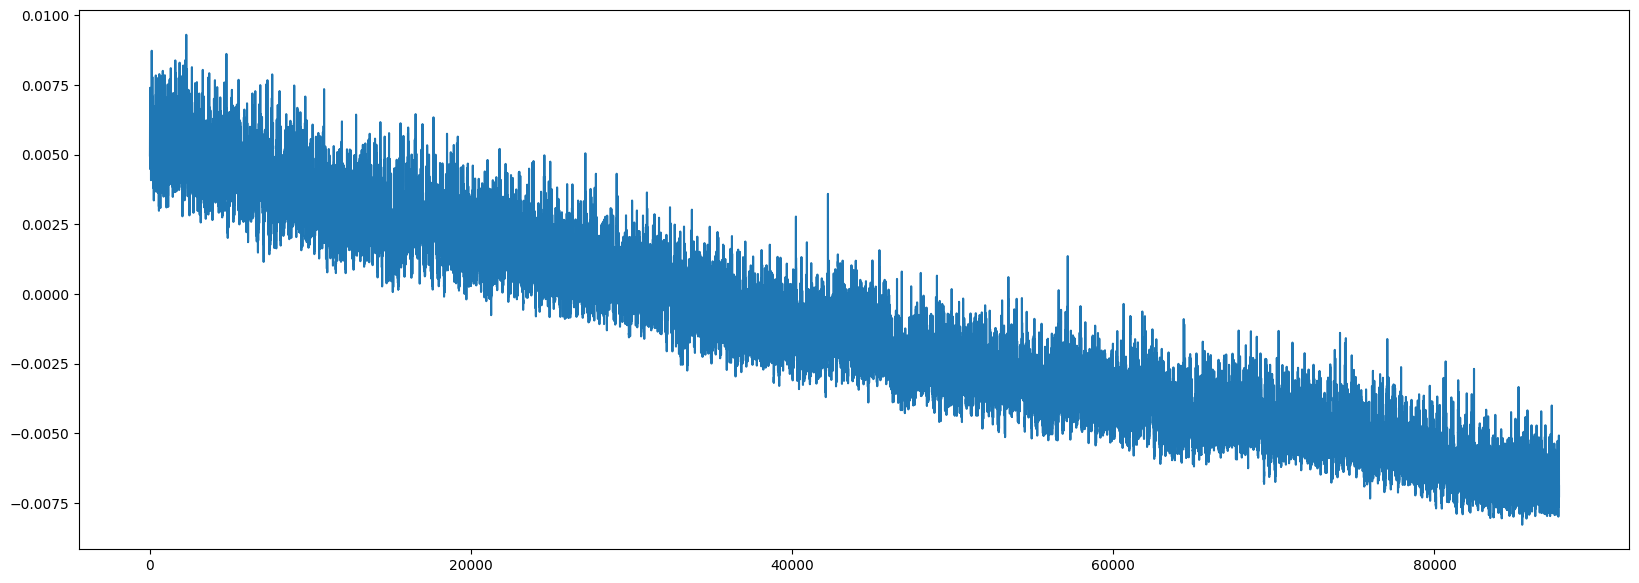

In [30]:
plt.figure(figsize=(20, 7))
plt.plot(similarity_arr)
plt.show()

In [33]:
np.argsort(similarity_arr)[::-1][:30]

array([2264,  112, 4763, 2219, 1580, 1848, 2263,  111, 2075, 4762,  113,
       2218, 2615, 1299, 2307, 2255, 3291, 2616,  801, 1591, 3694, 2220,
       2252,  585, 2076, 7616,  114, 1595,  930, 2254])

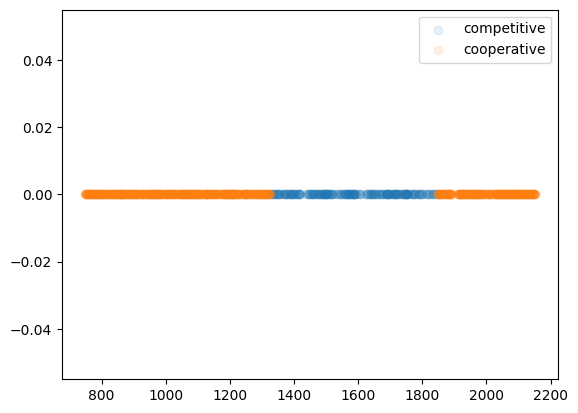

In [34]:
competitive_onset_values = competitive_events_df.query("trial_type == 'competitive'").onset
cooperative_onset_values = competitive_events_df.query("trial_type == 'cooperative'").onset

plt.scatter(competitive_onset_values, np.zeros_like(competitive_onset_values), alpha=0.1, label='competitive')
plt.scatter(cooperative_onset_values, np.zeros_like(cooperative_onset_values), alpha=0.1, label='cooperative')
plt.legend()
plt.show()

In [25]:
sessions_start = sorted([
    competitive_onset_values.iloc[0],
    cooperative_onset_values.iloc[0],
    competitive_onset_values[
        competitive_onset_values.diff().sort_values().index[-2]
    ],
    cooperative_onset_values[
        cooperative_onset_values.diff().sort_values().index[-2]
    ],
])
sessions_end = sorted([
    competitive_onset_values.iloc[-1],
    cooperative_onset_values.iloc[-1],
    competitive_onset_values[::-1][
        competitive_onset_values[::-1].diff().sort_values().index[0]
    ],
    cooperative_onset_values[::-1][
        cooperative_onset_values[::-1].diff().sort_values().index[0]
    ],
])

sessions_arr = list(zip(sessions_start, sessions_end))
sessions_arr

[(np.float64(614.012), np.float64(1065.8)),
 (np.float64(1986.576), np.float64(2433.484)),
 (np.float64(2907.808), np.float64(3353.008)),
 (np.float64(3829.584), np.float64(4278.34))]

For sub-15

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-dvpl{border-color:inherit;text-align:right;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-dvpl">     SHIFT (1/250 sec)<br>SESSION START (sec)</th>
    <th class="tg-0pky">10815</th>
    <th class="tg-0pky">23620</th>
    <th class="tg-0pky">29515</th>
    <th class="tg-0pky">43890</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-dvpl">1030</td>
    <td class="tg-0pky">+</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-dvpl">1933</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">+</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-dvpl">2375</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">+</td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-dvpl">3278</td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky">+</td>
  </tr>
</tbody>
</table>

### Collect shifts

In [11]:
def find_k_peaks(arr: np.ndarray, k: int = 4, delta_min: int = 1000):
    peaks = []

    for elem in arr:
        peaks_len = len(peaks)

        if peaks_len >= k:
            break
        elif peaks_len == 0:
            peaks.append(elem)
            continue

        to_add = True
        for peak in peaks:
            if abs(peak - elem) < delta_min:
                to_add = False
                break

        if to_add:
            peaks.append(elem)

    return sorted(peaks)


def find_continuous_sessions(onset_times, gap_threshold):
    # 1) Sort all onsets
    onsets = np.sort(np.asarray(onset_times))
    if len(onsets) == 0:
        return []

    # 2) Compute gaps between consecutive onsets
    diffs = np.diff(onsets)  # array of length (n_events-1)

    # 3) Wherever diff > gap_threshold, mark a "break"
    #    We record the indices where a new session begins (i+1)
    break_indices = np.where(diffs > gap_threshold)[0]

    # 4) Build start/end indices for each block
    #    - The very first session starts at index 0
    #    - Each break at diffs[i] means onsets[i] ends a session, onsets[i+1] begins the next.
    session_starts = np.concatenate([[0], break_indices + 1])
    session_ends   = np.concatenate([break_indices, [len(onsets) - 1]])

    # 5) Turn those into (start_time, end_time) pairs
    sessions = []
    for s_idx, e_idx in zip(session_starts, session_ends):
        start_t = float(onsets[s_idx])
        end_t   = float(onsets[e_idx])
        sessions.append((start_t, end_t))

    return sessions


def get_sessions_range(events_df: pd.DataFrame, sessions_delta: int = 60):
    return np.array(find_continuous_sessions(events_df.onset.values, sessions_delta)).reshape(-1, 2)


#### Variant 3

1. Calculate shift array for researcher, utilizing accelerometer data
2. Find k sessions timesteps, where k $\in \{ 3; 4 \}$
3. Find k peaks in shift array
5. Map session to peak in ascending order

In [12]:
!mkdir -p human-player/shifts_v3
SUB_IDS = ['0' * (n < 10) + str(n) for n in range(1, 26)]

for SUB_ID in tqdm(SUB_IDS):
    eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
    
    channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
    events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
    
    raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)

    events_subdf = events_df\
        .query("value in ('Subject_hit', 'Subject_receive')")\
        .query("trial_type in ('competitive', 'cooperative')") 
    
    participant_acc_channels = [
        'Participant_Paddle_Acc_X(g)',
        'Participant_Paddle_Acc_Y(g)',
        'Participant_Paddle_Acc_Z(g)'
    ]
    researcher_acc_channels = [
        'Researcher_Paddle_Acc_X(g)',
        'Researcher_Paddle_Acc_Y(g)',
        'Researcher_Paddle_Acc_Z(g)'
    ]
    acc_channels = participant_acc_channels + researcher_acc_channels
    acc_data = raw_eeg.pick_channels(acc_channels)
    acc_values = acc_data.get_data()
    acc_ttl_data = np.sqrt(np.sum(np.square(acc_values[3:]), axis=0))
    
    labels_data = np.zeros_like(acc_ttl_data)
    hit_indices = (events_df.query("value == 'Subject_receive'")['sample'] + 0.5).astype(int)
    labels_data[hit_indices.values] = 1
    max_shift = acc_ttl_data.size - events_df['sample'].astype(int).max()

    def calculate_corr(i):
        return np.corrcoef(acc_ttl_data[i:], labels_data[:labels_data.size-i])[0, 1]
    
    with Pool() as pool:
        similarity_arr = list(tqdm(pool.imap(calculate_corr, range(max_shift)), total=max_shift))

    sessions_arr = get_sessions_range(events_subdf)
    peaks_arr = find_k_peaks(np.argsort(similarity_arr)[::-1], k=len(sessions_arr))
    
    np.savez_compressed(
        f'human-player/shifts_v3/{SUB_ID}.npz',
        sessions=sessions_arr,
        peaks=peaks_arr,
    )
    
    gc.collect()

  0%|          | 0/25 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-01/eeg/sub-01_task-TableTennis_eeg.fdt
Reading 0 ... 785327  =      0.000 ...  3141.308 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/88709 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-02/eeg/sub-02_task-TableTennis_eeg.fdt
Reading 0 ... 1364632  =      0.000 ...  5458.528 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/44371 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-03/eeg/sub-03_task-TableTennis_eeg.fdt
Reading 0 ... 1099795  =      0.000 ...  4399.180 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/100901 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-04/eeg/sub-04_task-TableTennis_eeg.fdt
Reading 0 ... 1057035  =      0.000 ...  4228.140 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/385681 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-05/eeg/sub-05_task-TableTennis_eeg.fdt
Reading 0 ... 1038925  =      0.000 ...  4155.700 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/44860 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-06/eeg/sub-06_task-TableTennis_eeg.fdt
Reading 0 ... 1042908  =      0.000 ...  4171.632 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/58989 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-07/eeg/sub-07_task-TableTennis_eeg.fdt
Reading 0 ... 1174502  =      0.000 ...  4698.008 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/104588 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-08/eeg/sub-08_task-TableTennis_eeg.fdt
Reading 0 ... 1159909  =      0.000 ...  4639.636 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/96587 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-09/eeg/sub-09_task-TableTennis_eeg.fdt
Reading 0 ... 1146678  =      0.000 ...  4586.712 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/79593 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-10/eeg/sub-10_task-TableTennis_eeg.fdt
Reading 0 ... 1139465  =      0.000 ...  4557.860 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69785 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-11/eeg/sub-11_task-TableTennis_eeg.fdt
Reading 0 ... 1104856  =      0.000 ...  4419.424 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/51061 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-12/eeg/sub-12_task-TableTennis_eeg.fdt
Reading 0 ... 1111931  =      0.000 ...  4447.724 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/64968 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-13/eeg/sub-13_task-TableTennis_eeg.fdt
Reading 0 ... 1120665  =      0.000 ...  4482.660 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/58408 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-14/eeg/sub-14_task-TableTennis_eeg.fdt
Reading 0 ... 1129763  =      0.000 ...  4519.052 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/73918 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-15/eeg/sub-15_task-TableTennis_eeg.fdt
Reading 0 ... 1105756  =      0.000 ...  4423.024 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/56375 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-16/eeg/sub-16_task-TableTennis_eeg.fdt
Reading 0 ... 1151915  =      0.000 ...  4607.660 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/83889 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-17/eeg/sub-17_task-TableTennis_eeg.fdt
Reading 0 ... 1119558  =      0.000 ...  4478.232 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/61956 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-18/eeg/sub-18_task-TableTennis_eeg.fdt
Reading 0 ... 1155502  =      0.000 ...  4622.008 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/100154 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-19/eeg/sub-19_task-TableTennis_eeg.fdt
Reading 0 ... 1117344  =      0.000 ...  4469.376 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/56880 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-20/eeg/sub-20_task-TableTennis_eeg.fdt
Reading 0 ... 916387  =      0.000 ...  3665.548 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X(g)', 'Participant_Backpack_Acc_Y(g)', 'Participant_Backpack_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Re

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69020 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-21/eeg/sub-21_task-TableTennis_eeg.fdt
Reading 0 ... 1128360  =      0.000 ...  4513.440 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/63256 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-22/eeg/sub-22_task-TableTennis_eeg.fdt
Reading 0 ... 1108946  =      0.000 ...  4435.784 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuAcc :X(g):', 'Imu_1_ImuAcc :Y(g):', 'Imu_1_ImuAcc :Z(g):', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(u

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/51696 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-23/eeg/sub-23_task-TableTennis_eeg.fdt
Reading 0 ... 1053820  =      0.000 ...  4215.280 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8 :Z():', 'Im

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69728 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-24/eeg/sub-24_task-TableTennis_eeg.fdt
Reading 0 ... 1146790  =      0.000 ...  4587.160 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'IMU8_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/342 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-25/eeg/sub-25_task-TableTennis_eeg.fdt
Reading 0 ... 877573  =      0.000 ...  3510.292 secs...


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'IMU8_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650543861.py:10: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/36255 [00:00<?, ?it/s]

#### Variant 4

1. Find k sessions timesteps
2. Calculate shift array for each session with researcher (k shift arrays in total)
3. Find 1 peak for each shift array
4. Map session to peak in ascending order

In [ ]:
!mkdir -p human-player/shifts_v4
SUB_IDS = ['0' * (n < 10) + str(n) for n in range(1, 26)]
EPS = 0.001

for SUB_ID in tqdm(SUB_IDS):
    eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
    
    channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
    events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
    
    raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)

    events_subdf = events_df\
        .query("value in ('Subject_hit', 'Subject_receive')")\
        .query("trial_type in ('competitive', 'cooperative')") 
    
    participant_acc_channels = [
        'Participant_Paddle_Acc_X(g)',
        'Participant_Paddle_Acc_Y(g)',
        'Participant_Paddle_Acc_Z(g)'
    ]
    researcher_acc_channels = [
        'Researcher_Paddle_Acc_X(g)',
        'Researcher_Paddle_Acc_Y(g)',
        'Researcher_Paddle_Acc_Z(g)'
    ]
    acc_channels = participant_acc_channels + researcher_acc_channels
    acc_data = raw_eeg.pick_channels(acc_channels)
    acc_values = acc_data.get_data()
    acc_ttl_data = np.sqrt(np.sum(np.square(acc_values[3:]), axis=0))

    sessions_arr = get_sessions_range(events_subdf)
    peaks_arr = []
    max_shift = acc_ttl_data.size - events_df['sample'].astype(int).max()
    
    for start, end in sessions_arr:
        labels_data = np.zeros_like(acc_ttl_data)
        session_subdf = events_subdf\
            .query("value == 'Subject_receive'")\
            .query(f"{start - EPS} <= onset <= {end + EPS}")
        
        hit_indices = (session_subdf['sample'] + 0.5).astype(int)
        labels_data[hit_indices.values] = 1
    
        def calculate_corr(i):
            return np.corrcoef(acc_ttl_data[i:], labels_data[:labels_data.size-i])[0, 1]
        
        with Pool() as pool:
            similarity_arr = list(tqdm(pool.imap(calculate_corr, range(max_shift)), total=max_shift))
    
        peak = find_k_peaks(np.argsort(similarity_arr)[::-1], k=1)
        peaks_arr.append(peak)
    
    np.savez_compressed(
        f'human-player/shifts_v4/{SUB_ID}.npz',
        sessions=sessions_arr,
        peaks=peaks_arr,
    )
    
    gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-06/eeg/sub-06_task-TableTennis_eeg.fdt
Reading 0 ... 1042908  =      0.000 ...  4171.632 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/58989 [00:00<?, ?it/s]

  0%|          | 0/58989 [00:00<?, ?it/s]

  0%|          | 0/58989 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-07/eeg/sub-07_task-TableTennis_eeg.fdt
Reading 0 ... 1174502  =      0.000 ...  4698.008 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/104588 [00:00<?, ?it/s]

  0%|          | 0/104588 [00:00<?, ?it/s]

  0%|          | 0/104588 [00:00<?, ?it/s]

  0%|          | 0/104588 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-08/eeg/sub-08_task-TableTennis_eeg.fdt
Reading 0 ... 1159909  =      0.000 ...  4639.636 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/96587 [00:00<?, ?it/s]

  0%|          | 0/96587 [00:00<?, ?it/s]

  0%|          | 0/96587 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-09/eeg/sub-09_task-TableTennis_eeg.fdt
Reading 0 ... 1146678  =      0.000 ...  4586.712 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/79593 [00:00<?, ?it/s]

  0%|          | 0/79593 [00:00<?, ?it/s]

  0%|          | 0/79593 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-10/eeg/sub-10_task-TableTennis_eeg.fdt
Reading 0 ... 1139465  =      0.000 ...  4557.860 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69785 [00:00<?, ?it/s]

  0%|          | 0/69785 [00:00<?, ?it/s]

  0%|          | 0/69785 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-11/eeg/sub-11_task-TableTennis_eeg.fdt
Reading 0 ... 1104856  =      0.000 ...  4419.424 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/51061 [00:00<?, ?it/s]

  0%|          | 0/51061 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-12/eeg/sub-12_task-TableTennis_eeg.fdt
Reading 0 ... 1111931  =      0.000 ...  4447.724 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/64968 [00:00<?, ?it/s]

  0%|          | 0/64968 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/58408 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/73918 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-15/eeg/sub-15_task-TableTennis_eeg.fdt
Reading 0 ... 1105756  =      0.000 ...  4423.024 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/56375 [00:00<?, ?it/s]

  0%|          | 0/56375 [00:00<?, ?it/s]

  0%|          | 0/56375 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-16/eeg/sub-16_task-TableTennis_eeg.fdt
Reading 0 ... 1151915  =      0.000 ...  4607.660 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/83889 [00:00<?, ?it/s]

  0%|          | 0/83889 [00:00<?, ?it/s]

  0%|          | 0/83889 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-17/eeg/sub-17_task-TableTennis_eeg.fdt
Reading 0 ... 1119558  =      0.000 ...  4478.232 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/61956 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/100154 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-19/eeg/sub-19_task-TableTennis_eeg.fdt
Reading 0 ... 1117344  =      0.000 ...  4469.376 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/56880 [00:00<?, ?it/s]

  0%|          | 0/56880 [00:00<?, ?it/s]

  0%|          | 0/56880 [00:00<?, ?it/s]

  0%|          | 0/56880 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-20/eeg/sub-20_task-TableTennis_eeg.fdt
Reading 0 ... 916387  =      0.000 ...  3665.548 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X(g)', 'Participant_Backpack_Acc_Y(g)', 'Participant_Backpack_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Re

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/69020 [00:00<?, ?it/s]

  0%|          | 0/69020 [00:00<?, ?it/s]

  0%|          | 0/69020 [00:00<?, ?it/s]

  0%|          | 0/69020 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-21/eeg/sub-21_task-TableTennis_eeg.fdt
Reading 0 ... 1128360  =      0.000 ...  4513.440 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/63256 [00:00<?, ?it/s]

  0%|          | 0/63256 [00:00<?, ?it/s]

  0%|          | 0/63256 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-22/eeg/sub-22_task-TableTennis_eeg.fdt
Reading 0 ... 1108946  =      0.000 ...  4435.784 secs...


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuAcc :X(g):', 'Imu_1_ImuAcc :Y(g):', 'Imu_1_ImuAcc :Z(g):', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(u

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
/tmp/ipykernel_1155911/1650871764.py:11: RuntimeWarning: Not setting positions of 8 emg channels found in montage:
['LISCM', 'LSSCM', 'LSTrap', 'LITrap', 'RITrap', 'RISCM', 'RSSCM', 'RSTrap']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)


  0%|          | 0/51696 [00:00<?, ?it/s]

  0%|          | 0/51696 [00:00<?, ?it/s]

  0%|          | 0/51696 [00:00<?, ?it/s]

### Compare variants 3 and 4

In [19]:
sub_ids = ['0' * (n < 10) + str(n) for n in range(1, 26)]
shifts_v3 = [np.load(f'human-player/shifts_v3/{sub_id}.npz') for sub_id in sub_ids]
shifts_v4 = [np.load(f'human-player/shifts_v4/{sub_id}.npz') for sub_id in sub_ids]

for i in range(len(sub_ids)):
    shift_3 = shifts_v3[i]['peaks'].reshape(-1)
    shift_4 = shifts_v4[i]['peaks'].reshape(-1)

    print(i+1)
    print(shift_3)
    print(shift_4)

1
[61125]
[61125]
2
[ 2130 36398]
[ 2130 36398]
3
[16379 47584 80246 96504]
[16379 47584 80246 96504]
4
[    0  1272 18398]
[    0  1272 15635]
5
[ 1733 10335 27634 36117]
[ 1733 10335 27634 36117]
6
[27365 41754 54162]
[ 7390 27365 54162]
7
[10235 44722 65210 97822]
[10235 44722 65210 97822]
8
[21388 25456 85319]
[21388 54256 85319]
9
[ 8494 32223 63809]
[ 8494 32223 63809]
10
[14740 37406 44558]
[14740 37406 67505]
11
[ 6340 12202 25234]
[ 6340 25234 39469]
12
[22584 38522 48494]
[ 6532 22584 48494]
13
[ 1457 11946 24513 47580]
[ 1457 11946 24513 47580]
14
[25155 48278 66970]
[25155 48278 66970]
15
[10815 23619 43894]
[10816 23619 43894]
16
[41247 65229 70856]
[23168 41247 70856]
17
[ 5872 29634 44793 57835]
[ 5872 29634 44793 57835]
18
[23990 32539 98405]
[32539 59883 98405]
19
[ 9821 21163 38880 54979]
[ 9821 21164 38880 54979]
20
[ 3743 26059 46728 63001]
[ 3744 26059 46728 63001]
21
[10277 22684 54180]
[10277 22684 54180]
22
[ 2989 11499 26553 35513]
[ 2989 11499 26553 35513]
23


### Final shifts

Everything from v4

In [36]:
# In tennis forehand stroke studies using IMUs, acceleration peaks typically occur about 8–12 ms after actual ball contact.
# 12 ms = 12 / 1000 sec = 3 / 250 sec = 3 steps
EVENT_TO_PEAK_SHIFT = 3

!mkdir -p human-player/shifts_final

sub_ids = ['0' * (n < 10) + str(n) for n in range(1, 26)]
shifts_v3 = [np.load(f'human-player/shifts_v3/{sub_id}.npz') for sub_id in sub_ids]
shifts_v4 = [np.load(f'human-player/shifts_v4/{sub_id}.npz') for sub_id in sub_ids]

for i, sub_id in enumerate(sub_ids):
    shift = shifts_v4[i]

    np.savez_compressed(
        f'human-player/shifts_final/{sub_id}.npz',
        sessions=shift['sessions'],
        peaks=shift['peaks'] - EVENT_TO_PEAK_SHIFT,
    )

## Data collection pipeline

In [ ]:
!mkdir -p human-player/data/

In [38]:
def define_successful_hit(events_df: pd.DataFrame, result_col: str = 'score') -> pd.DataFrame:
    df = events_df.copy()
    df.dropna(subset=['orignum'], inplace=True)
    df = df.query(
        "trial_type in ('cooperative', 'competitive')"
    ).assign(
        timedelta=df.query("value != 'M  1'").onset.diff(periods=-1).abs()
    )
    df = df.assign(
        session_end=df.timedelta > 4
    )
    
    df['score'] = None
    index = df.index

    df.loc[index[df.performance.isin([2, 3])], 'score'] = -1
    df.loc[index[(df.session_end) & (df.performance == 1)], 'score'] = 1
    df.loc[index[(~df.session_end) & (df.performance == 1)], 'score'] = 0
    df.loc[index[(df.score == 0) & (df.score.shift(-1) == -1)], 'score'] = 2

    df.drop(columns=['session_end', 'timedelta'], inplace=True)
    return df

In [39]:
PARTICIPANT_CHANNELS = [
    'Fp1', 'AFp1', 'AFz', 'AF3', 'AF7', 'AFF5h', 'AFF1h', 'F1', 'F3',
    'F5', 'F7', 'F9', 'FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h',
    'FCz', 'FC1', 'FC3', 'FC5', 'FT7', 'FT9', 'FTT9h', 'FTT7h',
    'FCC5h', 'FCC3h', 'FCC1h', 'C1', 'C3', 'C5', 'T7', 'TTP7h',
    'CCP5h', 'CCP3h', 'CCP1h', 'CP1', 'CP3', 'CP5', 'TP7', 'TPP9h',
    'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'P1', 'P3', 'P5', 'P7',
    'PPO5h', 'PPO1h', 'POz', 'PO3', 'PO7', 'PPO9h', 'O1', 'POO1',
    'OI1h', 'Iz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'FTT10h', 'FTT8h',
    'FCC6h', 'FCC4h', 'FCC2h', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10',
    'FFT10h', 'FFT8h', 'FFC6h', 'FFC4h', 'FFC2h', 'Fz', 'F2', 'F4',
    'F6', 'F8', 'F10', 'AFF6h', 'AFF2h', 'AF4', 'AF8', 'FP2', 'AFp2',
    'Oz', 'OI2h', 'POO10h', 'O2', 'POO2', 'PO4', 'PO8', 'PPO10h',
    'PPO6h', 'PPO2h', 'Pz', 'P2', 'P4', 'P6', 'P8', 'TPP10h', 'TPP8h',
    'CPP6h', 'CPP4h', 'CPP2h', 'CP2', 'CP4', 'CP6', 'TP8', 'TTP8h',
    'CCP6h', 'CCP4h', 'CCP2h', 'N-Fp1', 'N-AFp1', 'N-AFz', 'N-AF3',
    'N-AF7', 'N-AFF5h', 'N-AFF1h', 'N-F1', 'N-F3', 'N-F5', 'N-F7',
    'N-F9', 'N-FFT9h', 'N-FFT7h', 'N-FFC5h', 'N-FFC3h', 'N-FFC1h',
    'N-FCz', 'N-FC1', 'N-FC3', 'N-FC5', 'N-FT7', 'N-FT9', 'N-FTT9h',
    'N-FTT7h', 'N-FCC5h', 'N-FCC3h', 'N-FCC1h', 'N-C1', 'N-C3', 'N-C5',
    'N-T7', 'N-TTP7h', 'N-CCP5h', 'N-CCP3h', 'N-CCP1h', 'N-CP1',
    'N-CP3', 'N-CP5', 'N-TP7', 'N-TPP9h', 'N-TPP7h', 'N-CPP5h',
    'N-CPP3h', 'N-CPP1h', 'N-P1', 'N-P3', 'N-P5', 'N-P7', 'N-PPO5h',
    'N-PPO1h', 'N-POz', 'N-PO3', 'N-PO7', 'N-PPO9h', 'N-O1', 'N-POO1',
    'N-OI1h', 'N-Iz', 'N-Cz', 'N-C2', 'N-C4', 'N-C6', 'N-T8',
    'N-FTT10h', 'N-FTT8h', 'N-FCC6h', 'N-FCC4h', 'N-FCC2h', 'N-FC2',
    'N-FC4', 'N-FC6', 'N-FT8', 'N-FT10', 'N-FFT10h', 'N-FFT8h',
    'N-FFC6h', 'N-FFC4h', 'N-FFC2h', 'N-Fz', 'N-F2', 'N-F4', 'N-F6',
    'N-F8', 'N-F10', 'N-AFF6h', 'N-AFF2h', 'N-AF4', 'N-AF8', 'N-FP2',
    'N-AFp2', 'N-Oz', 'N-OI2h', 'N-POO10h', 'N-O2', 'N-POO2', 'N-PO4',
    'N-PO8', 'N-PPO10h', 'N-PPO6h', 'N-PPO2h', 'N-Pz', 'N-P2', 'N-P4',
    'N-P6', 'N-P8', 'N-TPP10h', 'N-TPP8h', 'N-CPP6h', 'N-CPP4h',
    'N-CPP2h', 'N-CP2', 'N-CP4', 'N-CP6', 'N-TP8', 'N-TTP8h',
    'N-CCP6h', 'N-CCP4h', 'N-CCP2h', 'LISCM', 'LSSCM', 'LSTrap',
    'LITrap', 'CGY-x', 'CGY-y', 'CGY-z', 'RITrap', 'RISCM', 'RSSCM',
    'RSTrap', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z',
    'NWR-x', 'NWR-y', 'NWR-z', 'Participant_Paddle_Acc_X(g)',
    'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)'
]
T_LEN = 1
EPS = 1e-3

SUB_IDS = ['0' * (n < 10) + str(n) for n in range(1, 26)]

for SUB_ID in tqdm(SUB_IDS):
    eeg_dirname = os.path.join(DATA_PATH, f'sub-{SUB_ID}', 'eeg/')
    
    channels_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_channels.tsv', sep='\t')
    events_df = pd.read_csv(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_events.tsv', sep='\t')
    shift_arr = np.load(f'human-player/shifts_final/{SUB_ID}.npz', allow_pickle=True)
    
    raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + f'sub-{SUB_ID}_task-TableTennis_eeg.set', preload=True)
    eeg_file = os.path.join(eeg_dirname, f'sub-{SUB_ID}_task-TableTennis_eeg.set')
    mat = scipy.io.loadmat(eeg_file, struct_as_record=False, squeeze_me=True)
    
    eeg_channels = channels_df[channels_df['type'] == 'EEG']['name'].tolist()
    emg_channels = channels_df[channels_df['type'] == 'EMG']['name'].tolist()
    misc_channels = channels_df[channels_df['type'] == 'MISC']['name'].tolist()
    
    # Set channel types
    channel_types = {}
    for ch in raw_eeg.ch_names:
        if ch in eeg_channels:
            channel_types[ch] = 'eeg'
        elif ch in emg_channels:
            channel_types[ch] = 'emg'
        else:
            channel_types[ch] = 'misc'  # Includes IMU and other sensors
    
    raw_eeg.set_channel_types(channel_types)
    
    events_df['bounces'] = None
    events_df['performance'] = None
    events_df['device'] = None
    events_df['orignum'] = None
    
    for i, row in events_df.iterrows():
        mat_event = mat['event'][i]
        
        assert mat_event.type == row['value'], "asynchronous status event_type"
        assert row['trial_type'] == 'STATUS' or mat_event.condlabel == row['trial_type'], "asynchronous status"
        assert np.abs(mat_event.latency - row['sample']) <= 2, "asynchronous time"
        
        if not isinstance(mat_event.bounces, np.ndarray):
            events_df.at[i, 'bounces'] = mat_event.bounces
    
        if not isinstance(mat_event.performance, np.ndarray):
            events_df.at[i, 'performance'] = mat_event.performance
    
        if not isinstance(mat_event.code, np.ndarray):
            events_df.at[i, 'device'] = mat_event.code
    
        if not isinstance(mat_event.orignum, np.ndarray):
            events_df.at[i, 'orignum'] = mat_event.orignum
    
    
    events_df_with_trg = define_successful_hit(events_df)
    events_df_with_trg.dropna(subset=['score'], inplace=True)
    
    filtered_events_df = events_df_with_trg\
        .query("value == 'Subject_hit'")\
        .query("trial_type in ('competitive', 'cooperative')")
    filtered_events_df['shifted_sample'] = None
    
    for ind, row in filtered_events_df.iterrows():
        sample, onset = row['sample'], row['onset']
        delta = None
    
        for i, (session_start, session_end) in enumerate(shift_arr['sessions']):
            if session_start - EPS <= onset <= session_end + EPS:
                delta = shift_arr['peaks'][i]
                break
        
        filtered_events_df.at[ind, 'shifted_sample'] = sample + delta
    
    filtered_events_df['shifted_sample'] = filtered_events_df['shifted_sample'].astype(int)
    
    acc_data = raw_eeg.pick_channels(PARTICIPANT_CHANNELS)
    sfreq = raw_eeg.info['sfreq']
    window_size = int(T_LEN * sfreq)
    data_hit = []
    
    for idx, row in filtered_events_df.iterrows():
        event_type = row['value']
        sample_index = row['shifted_sample']
        
        start_index = sample_index - window_size
        end_index = sample_index
        
        # Skip this event if the window is out of bounds
        if start_index < 0 or end_index > acc_data.n_times:
            continue
        
        data_segment = acc_data.get_data(start=start_index, stop=end_index)
        data_hit.append(data_segment)
    
    data_hit_npy = np.array(data_hit)
    
    data_hit_target = filtered_events_df.score.values
    data_hit_timesteps = filtered_events_df.onset.values
    
    np.savez_compressed(
        f'human-player/data/signals_{SUB_ID}.npz',
        signals=data_hit_npy,
        target=data_hit_target,
        timesteps=data_hit_timesteps,
        channels=PARTICIPANT_CHANNELS
    )
    
    gc.collect()

  0%|          | 0/25 [00:00<?, ?it/s]

Reading /data/vladimiroved/realWorldTableTennis/sub-01/eeg/sub-01_task-TableTennis_eeg.fdt
Reading 0 ... 785327  =      0.000 ...  3141.308 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-02/eeg/sub-02_task-TableTennis_eeg.fdt
Reading 0 ... 1364632  =      0.000 ...  5458.528 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-03/eeg/sub-03_task-TableTennis_eeg.fdt
Reading 0 ... 1099795  =      0.000 ...  4399.180 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-04/eeg/sub-04_task-TableTennis_eeg.fdt
Reading 0 ... 1057035  =      0.000 ...  4228.140 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-05/eeg/sub-05_task-TableTennis_eeg.fdt
Reading 0 ... 1038925  =      0.000 ...  4155.700 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-06/eeg/sub-06_task-TableTennis_eeg.fdt
Reading 0 ... 1042908  =      0.000 ...  4171.632 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_3 :W():', 'Imu_3 :X():', 'Imu_3 :Y():', 'Imu_3 :Z():', 'Imu_3_ImuGyro :X(D/s):', 'Imu_3_ImuGyro :Y(D/s):', 'Imu_3_ImuGyro :Z(D/s):', 'Imu_3_ImuMag :X(uT):', 'Imu_3_ImuMag :Y(uT):', 'Imu_3_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_5 :W():', 'Imu_5 :X():', 'Imu_5 :Y():', 'Imu_5 :Z():', 'Imu_5_ImuGyro 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-07/eeg/sub-07_task-TableTennis_eeg.fdt
Reading 0 ... 1174502  =      0.000 ...  4698.008 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-08/eeg/sub-08_task-TableTennis_eeg.fdt
Reading 0 ... 1159909  =      0.000 ...  4639.636 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)', 'Table_OtherSide_Acc_X(g)', 'Table_Ot

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-09/eeg/sub-09_task-TableTennis_eeg.fdt
Reading 0 ... 1146678  =      0.000 ...  4586.712 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-10/eeg/sub-10_task-TableTennis_eeg.fdt
Reading 0 ... 1139465  =      0.000 ...  4557.860 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-11/eeg/sub-11_task-TableTennis_eeg.fdt
Reading 0 ... 1104856  =      0.000 ...  4419.424 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-12/eeg/sub-12_task-TableTennis_eeg.fdt
Reading 0 ... 1111931  =      0.000 ...  4447.724 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-13/eeg/sub-13_task-TableTennis_eeg.fdt
Reading 0 ... 1120665  =      0.000 ...  4482.660 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-14/eeg/sub-14_task-TableTennis_eeg.fdt
Reading 0 ... 1129763  =      0.000 ...  4519.052 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-15/eeg/sub-15_task-TableTennis_eeg.fdt
Reading 0 ... 1105756  =      0.000 ...  4423.024 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-16/eeg/sub-16_task-TableTennis_eeg.fdt
Reading 0 ... 1151915  =      0.000 ...  4607.660 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-17/eeg/sub-17_task-TableTennis_eeg.fdt
Reading 0 ... 1119558  =      0.000 ...  4478.232 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-18/eeg/sub-18_task-TableTennis_eeg.fdt
Reading 0 ... 1155502  =      0.000 ...  4622.008 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-19/eeg/sub-19_task-TableTennis_eeg.fdt
Reading 0 ... 1117344  =      0.000 ...  4469.376 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-20/eeg/sub-20_task-TableTennis_eeg.fdt
Reading 0 ... 916387  =      0.000 ...  3665.548 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Backpack_Acc_X(g)', 'Participant_Backpack_Acc_Y(g)', 'Participant_Backpack_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Re

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-21/eeg/sub-21_task-TableTennis_eeg.fdt
Reading 0 ... 1128360  =      0.000 ...  4513.440 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Net_Acc_X(g)', 'Net_Acc_Y(g)', 'Net_Acc_Z(g)', 'Participant_Ba

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-22/eeg/sub-22_task-TableTennis_eeg.fdt
Reading 0 ... 1108946  =      0.000 ...  4435.784 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuAcc :X(g):', 'Imu_1_ImuAcc :Y(g):', 'Imu_1_ImuAcc :Z(g):', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(u

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-23/eeg/sub-23_task-TableTennis_eeg.fdt
Reading 0 ... 1053820  =      0.000 ...  4215.280 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8 :Z():', 'Im

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-24/eeg/sub-24_task-TableTennis_eeg.fdt
Reading 0 ... 1146790  =      0.000 ...  4587.160 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'IMU8_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /data/vladimiroved/realWorldTableTennis/sub-25/eeg/sub-25_task-TableTennis_eeg.fdt
Reading 0 ... 877573  =      0.000 ...  3510.292 secs...


/tmp/ipykernel_1155911/3376151839.py:52: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'IMU1_RMS', 'IMU8_RMS', 'Imu_1 :W():', 'Imu_1 :X():', 'Imu_1 :Y():', 'Imu_1 :Z():', 'Imu_1_ImuGyro :X(D/s):', 'Imu_1_ImuGyro :Y(D/s):', 'Imu_1_ImuGyro :Z(D/s):', 'Imu_1_ImuMag :X(uT):', 'Imu_1_ImuMag :Y(uT):', 'Imu_1_ImuMag :Z(uT):', 'Imu_2 :W():', 'Imu_2 :X():', 'Imu_2 :Y():', 'Imu_2 :Z():', 'Imu_2_ImuGyro :X(D/s):', 'Imu_2_ImuGyro :Y(D/s):', 'Imu_2_ImuGyro :Z(D/s):', 'Imu_2_ImuMag :X(uT):', 'Imu_2_ImuMag :Y(uT):', 'Imu_2_ImuMag :Z(uT):', 'Imu_4 :W():', 'Imu_4 :X():', 'Imu_4 :Y():', 'Imu_4 :Z():', 'Imu_4_ImuGyro :X(D/s):', 'Imu_4_ImuGyro :Y(D/s):', 'Imu_4_ImuGyro :Z(D/s):', 'Imu_4_ImuMag :X(uT):', 'Imu_4_ImuMag :Y(uT):', 'Imu_4_ImuMag :Z(uT):', 'Imu_8 :W():', 'Imu_8 :X():', 'Imu_8 :Y():', 'Imu_8

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


## Pre-calculate channel-wise mean and std

In [56]:
!mkdir -p human-player/signals-stats

In [54]:
eeg_scaler = StandardScaler()
imu_scaler = StandardScaler()

root = Path("human-player/data")
for fn in tqdm(sorted(root.glob("signals_*.npz"))):
    d = np.load(fn, allow_pickle=True)
    signals = d['signals'].astype(np.float32)
    channels = d['channels']

    # ----- split scalp EEG vs noise vs "other" -----
    # Assumption: first block = scalp, second block = noise (same length)
    idx_noise_start = np.where(np.char.startswith(channels, 'N-'))[0][0]
    scalp = signals[:, :idx_noise_start, :]
    noise = signals[:, idx_noise_start:2*idx_noise_start, :]
    other = signals[:, 2*idx_noise_start:, :]
    eeg = scalp - noise  # (N_eeg, T)
    imu = other

    # reshape so samples × features
    n_trials, n_ch_eeg, n_times = eeg.shape
    eeg_batch = eeg.transpose(0,2,1).reshape(-1, n_ch_eeg)  # (n_trials*n_times, n_ch_eeg)
    imu_batch = imu.transpose(0,2,1).reshape(-1, imu.shape[1])  # (n_trials*n_times, n_ch_imu)

    eeg_scaler.partial_fit(eeg_batch)
    imu_scaler.partial_fit(imu_batch)

# after all files:
eeg_mean = eeg_scaler.mean_       # shape (n_ch_eeg,)
eeg_std  = np.sqrt(eeg_scaler.var_)   # var_ stores unbiased-true variance

imu_mean = imu_scaler.mean_       # shape (n_ch_imu,)
imu_std  = np.sqrt(imu_scaler.var_)

print("EEG mean:", eeg_mean.shape, "EEG std:", eeg_std.shape)
print("IMU mean:", imu_mean.shape, "IMU std:", imu_std.shape)

  0%|          | 0/25 [00:00<?, ?it/s]

EEG mean: (119,) EEG std: (119,)
IMU mean: (23,) IMU std: (23,)


In [58]:
np.save('human-player/signals-stats/eeg_mean.npy', eeg_mean)
np.save('human-player/signals-stats/eeg_std.npy', eeg_std)
np.save('human-player/signals-stats/imu_mean.npy', imu_mean)
np.save('human-player/signals-stats/imu_std.npy', imu_std)